# Assignment 3: Molecular Dynamics
## Martin Colahan


## Instructions:

This notebook is hosted on Github: [Github](https://github.com/mcolahan/mole-sim)
and can be accessed through the binder button on the README.md file or at the following link:[Code can be run here](https://mybinder.org/v2/gh/mcolahan/mole-sim/master?filepath=MD%20Assignment%203.ipynb)

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/mcolahan/mole-sim/master?filepath=MD%20Assignment%203.ipynb)

The notebook can also be downloaded from Github and run locally using Jupyter. The easiest way to set up the environment is to install python via Anaconda.

To run a code cell, click on the cell and press Shift+Enter.

CSV files that are imported via Pandas can be found at the Github repository linked above.


## Python and package versions:


In [1]:
import sys
import numpy
import matplotlib

print(f'Python: {sys.version}')
print(f'Numpy: {numpy.__version__}')
print(f'Matplotlib: {matplotlib.__version__}')

Python: 3.7.2 (default, Feb 21 2019, 17:35:59) [MSC v.1915 64 bit (AMD64)]
Numpy: 1.16.2
Matplotlib: 3.0.2


# Assigment Info:
## Q1 
<ol> <li type="a"> 
    Adapt microcanonical ensemble MD code from 2nd assignment to calculate instantaneous temperature and pressure and output it with potential, kinetic, and total energies.
    </li>
<li type="a"> 
    Use a Berendsen thermostat to simulate a canonical ensemble.
</li>
</ol>

## Q2
<ol>
    <li type="a">
        Use the canonical ensemble code to simulate many different state points (P,T, $\rho$).Estimate van der Waals EOS coefficients. 
    </li>
    <li type="a">
        Use the EOS from (a) to predict P at T = 0.7 and $\rho$ = 1.0. Check with a MD simulation to determine difference from prediction.  
    </li>
    <li type="a">
        Calculate the radial distribution function for T=0.7 and $\rho$ = 1
    </li>


# Code
Please run the cell below so required functions are loaded.

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def Lennard_Jones(r, dist_cutoff=3):
    # r is a 2D array where row i, and col j correspond to particle i and dimension j (x:0, y:1, z:2)
    # outputs: a 3D array where f[i,j,k] is the force on i because of j in dimension k,
    # sum of potential energy, and virial for instantaneous pressure calcs
    
    #             part i    part j  (x,y,z)

    f = np.zeros([n_parts, n_parts, n_dims])
    E_p_sum = 0
    
    virial = 0    # for pressure calculation
    
    for i in range(n_parts):
        # get position vectors and distances between particles 
        r_ij_vect = r[i,:] - r[(i+1):,:]   
        r_ij_vect -= np.around(r_ij_vect / box_size) * box_size   #pbc
        
        r_ij = np.sqrt(np.sum(r_ij_vect**2, axis=1))   # magnitude (norm) of r_ij_vect

        # get index of particles within range of the spherical cutoff
        parts_in_range = np.where(r_ij <= dist_cutoff)[0]
        
        # distance magnitude of particles within the spherical cutoff
        r_near = r_ij[parts_in_range]   
        
        # Lennard Jones
        # eq 5.3 in Allen and Tildesley 2nd ed
        # fij = -du(rij)/dr * unit vector of r_ij_vect
        f_mag = np.zeros([n_parts-i-1])
        f_mag[parts_in_range] = 24 * epsilon / r_near * (2 *
                (sigma/r_near) ** 12 - (sigma/r_near) ** 6)
                
        # new axis converts 1D array to a 2D array 
        f_vect = f_mag[:, np.newaxis] * r_ij_vect/r_ij[:, np.newaxis]
        f[i, (i+1):, :] =  f_vect
        f[(i+1):, i, :] = -f_vect   # newton's 3rd law
        
        
        virial += np.sum(r_ij_vect * f_vect)
        
        Ep = np.zeros([n_parts - i - 1])
        Ep[parts_in_range] = 4 * epsilon * ((sigma/r_near) ** 12 - (sigma/r_near) ** 6)
        
        E_p_sum += np.sum(Ep)

    virial = virial / 3
    return f, E_p_sum, virial


def molecular_dynamics(part_props, ensemble, box_size, time_props, Tsp=None, deltat_tao = 0.005, 
                       save_csv=False, sim_name="", return_results=True):
    global n_parts, n_dims, sigma, epsilon, m

    epsilon = part_props['epsilon']
    sigma = part_props['sigma']
    m = part_props['mass']
    number_density = part_props['density']
    min_dist = part_props['min_dist']      # minimum distance between particles in initialization
    
    n_dims = len(box_size)

    delta_t = time_props['delta_t']        # time between time steps
    n_timesteps = time_props['timesteps']     # how many time steps?
    output_steps = time_props['steps between out']
    dist_cutoff = 3 * sigma
    
    time =  np.arange(0, n_timesteps * delta_t, delta_t)
    time_out = time[::output_steps]   # get time after output_steps steps 
    n_outputs = np.shape(time_out)[0]
    
    # Ensemble considerations:
    if ensemble == 'Microcanonical':
        const_T = False
    elif ensemble == 'Canonical':
        const_T = True
    else:
        raise ValueError('Ensemble type not defined.')
        

    ## Initialization and determining particle starting locations (from assignment 1)

    n_parts = int(number_density * np.prod(box_size))
    
    V = np.prod(box_size)
    Kb = 1
    
    init_locs = np.random.rand(n_parts, n_dims) * box_size
    min_dists = []
    for i in range(n_parts):
        continue_looping = True
        if i == 0:
            continue
        loop_count = 0
        while continue_looping == True:
            if loop_count > 10000:
                raise InterruptedError('Loop was interrupted')

            dr = init_locs[i,:] - init_locs[:i,:]
            dr = dr - np.around(dr / box_size) * box_size   # PBC 
            dist = np.sqrt(np.sum(dr**2, axis=1))

            if (dist < min_dist).any() == True:
                init_locs[i, :] = np.random.rand(1, n_dims) * box_size
            else:
                continue_looping = False
                min_dists.append(min(dist))

            loop_count += 1


    ## Time Integration

    #initialize position and velocity arrays (indices of arrays: particles, dimensions, time)
    # e.g., r[i, :, k] is position of particle i in all dimensions (x, y, z) at time k
    r = np.zeros([n_parts, n_dims, n_timesteps+1])   
    r[:, :, 0] = init_locs
    v = np.zeros([n_parts, n_dims, n_timesteps+1])
    a = np.zeros([n_parts, n_dims])

    # outputs init
    r_out = np.zeros([n_parts, n_dims, n_outputs])
    v_out = np.zeros([n_parts, n_dims, n_outputs])
    Ep = np.zeros(n_outputs)
    Ek = np.zeros(n_outputs)
    E = np.zeros(n_outputs)
    P = np.zeros(n_outputs)
    T = np.zeros(n_outputs)
    
    out_iter = 0

#     printed = False    # for debugging purposes

    for t in time:
        if t == 0:
            r = init_locs
            v = np.zeros([n_parts, n_dims])
            
            # Calculate initial acceleration
            f, pot_energy, virial = Lennard_Jones(r[:,:], dist_cutoff=dist_cutoff)
            f_vect = np.sum(f, axis=1) 
            a_vect = f_vect / m
            

        # using velocity-verlet algorithm
        v_halfdt = v + 0.5*delta_t * a_vect
        r = r + delta_t * v_halfdt

        # check if out of box and update if so
        r = r - np.floor(r / box_size) * box_size

        # update forces and acceleration with new r
        f, pot_energy, virial = Lennard_Jones(r)
        f_vect = np.sum(f, axis=1) 
        a_vect = f_vect / m

        v = v_halfdt + 0.5 * delta_t * a_vect

        if const_T == True:
            v_mag = np.sqrt(np.sum(v**2, axis=1))
            KE = np.sum(0.5 * m * v_mag**2)
            T_inst = 2 * KE / (3*(n_parts -1) * Kb)
            # Berendesen thermostat
            lam = np.sqrt(1 + deltat_tao * (Tsp / T_inst - 1))

            v *= lam
        
        v_mag = np.sqrt(np.sum(v**2, axis=1))
        KE = np.sum(0.5 * m * v_mag**2)
        T_inst = 2 * KE / (3*(n_parts -1) * Kb) 
        
        P_inst = number_density * T_inst + virial/V
        
        if t in time_out:
            r_out[:,:,out_iter] = r
            v_out[:,:,out_iter] = v
            Ek[out_iter] = KE
            Ep[out_iter] = pot_energy
            E[out_iter] = KE + pot_energy
            T[out_iter] = T_inst
            P[out_iter] = P_inst
            
            out_iter += 1

    if save_csv == True:
        cols = ['t', 'E', 'Ek', 'Ep', 'T', 'P']
        out_df = pd.DataFrame(np.array([time_out, E, Ek, Ep, T, P]).T, columns=cols)
        
        time_df = pd.DataFrame(time_out, columns=pd.MultiIndex.from_tuples([('t','t')]))

        dims = ['x', 'y', 'z']
        mult_ind = pd.MultiIndex.from_product([np.arange(n_parts), dims])
        r_df = pd.DataFrame(columns=mult_ind)
        r_df = pd.concat([time_df, r_df])
        v_df = r_df.copy()
        for i in range(n_outputs):
            for part in range(n_parts):
                r_df.loc[i, [part][:]] = r_out[part, :, i] 
                v_df.loc[i, [part][:]] = v_out[part, :, i]
                
        r_df.to_csv(sim_name + ' - position.csv')
        v_df.to_csv(sim_name + ' - velocity.csv')
        out_df.to_csv(sim_name + ' - ETP.csv')

    if return_results == True:
        return time_out, r_out, v_out, E, Ek, Ep, T, P
            
            

## Q1:
Code was adjusted above to run simulations in the canonical ensemble (constant temperature, volume, and particle count).
The below simulation can be used to check vs the known thermodynamic point (T=3.0, density=0.5, and P=2.479±0.003)

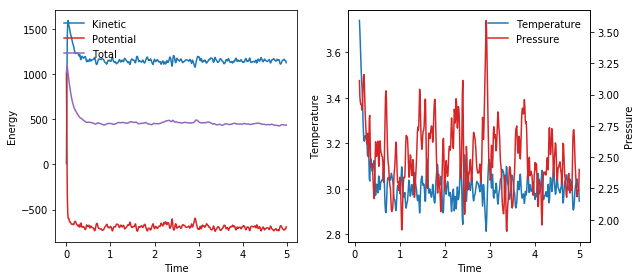

In [6]:
%matplotlib inline

box_size = np.array([8,8,8])    # (x, y, z)
part_props = {
    'epsilon': 1,
    'sigma': 1, 
    'mass': 1,
    'density': 0.5,
    'min_dist': 0.8,
}
time_props = {
    'delta_t': 0.0005,
    'timesteps': 10000,
    'steps between out': 20    # output every n_steps steps 
}

t, r, v, E, Ek, Ep, T, P = molecular_dynamics(part_props, 'Canonical', box_size, time_props, Tsp=3, 
                                              save_csv=True, return_results=True, sim_name="Q1-known")


## Post Processing
# plot energies, Temp, and Pressure
plt.figure(figsize=[9,4])
# left plot
plt.subplot(121)

plt.plot(t, Ek, label='Kinetic', c='C0')
plt.plot(t, Ep, label='Potential', c='C3')
plt.plot(t, E, label='Total', c='C4')
plt.ylabel('Energy')
plt.xlabel('Time')
plt.legend(frameon=False)

# right plot
ax_l = plt.subplot(122)
temp=plt.plot(t[10:], T[10:], label='Temperature', c='C0')
plt.ylabel('Temperature')
plt.xlabel('Time')
ax_r = ax_l.twinx()
pres=plt.plot(t[10:], P[10:], label='Pressure', c='C3')
plt.ylabel('Pressure')
lines = temp + pres
labels = [l.get_label() for l in lines]
ax_l.legend(lines, labels,frameon=False)

plt.tight_layout()
plt.show()

Simulate a canonical ensemble at T=2 and density=0.5:

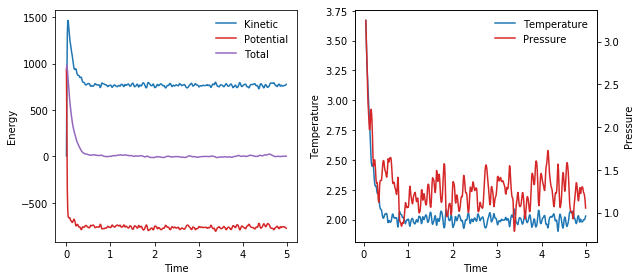

In [7]:
%matplotlib inline

box_size = np.array([8,8,8])    # (x, y, z)
part_props = {
    'epsilon': 1,
    'sigma': 1, 
    'mass': 1,
    'density': 0.5,
    'min_dist': 0.8,
}
time_props = {
    'delta_t': 0.0005,
    'timesteps': 10000,
    'steps between out': 20    # output every n_steps steps 
}

t, r, v, E, Ek, Ep, T, P = molecular_dynamics(part_props, 'Canonical', box_size, time_props, Tsp=2, 
                                              save_csv=True, return_results=True, sim_name="Q1-unknown T=2")


## Post Processing
# plot energies, Temp, and Pressure
plt.figure(figsize=[9,4])
# left plot
plt.subplot(121)

plt.plot(t, Ek, label='Kinetic', c='C0')
plt.plot(t, Ep, label='Potential', c='C3')
plt.plot(t, E, label='Total', c='C4')
plt.ylabel('Energy')
plt.xlabel('Time')
plt.legend(frameon=False)

# right plot
ax_l = plt.subplot(122)
temp=plt.plot(t[5:], T[5:], label='Temperature', c='C0')
plt.ylabel('Temperature')
plt.xlabel('Time')
ax_r = ax_l.twinx()
pres=plt.plot(t[5:], P[5:], label='Pressure', c='C3')
plt.ylabel('Pressure')
lines = temp + pres
labels = [l.get_label() for l in lines]
ax_l.legend(lines, labels,frameon=False)

plt.tight_layout()
plt.show()

# Q2
Estimation of van der Waals coefficients 

In [23]:
from IPython.display import display
import ipywidgets as widgets

box_size = np.array([8,8,8])    # (x, y, z)
part_props = {
    'epsilon': 1,
    'sigma': 1, 
    'mass': 1,
    'density': 0.5,
    'min_dist': 0.8,
}
time_props = {
    'delta_t': 0.001,
    'timesteps': 5000,
    'steps between out': 20    # output every n_steps steps 
}

densities = np.array([0.2, 0.4, 0.6, 0.8, 1.1])
temps = np.array([0.8, 1.2, 3, 5])
conditions = []

for i in densities:
    for j in temps:
        conditions.append((round(i,2),round(j,2)))
cond_count = len(conditions)
        
prog_widg = widgets.IntProgress(
    value=0,
    min=0,
    max=cond_count,
    step=1,
    description='Simulation:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    orientation='horizontal'
)
display(prog_widg)        
        
Pcalced = []
#time_out, r_out, v_out, E, Ek, Ep, T, P
break_cond = False

P_list = []
i = 0
for cond in conditions:
    rho = cond[0]
    T = cond[1]
    part_props['density'] = rho
    prog_widg.description = f'Sim: {cond}'
    _, _, _, _, _, _, _, P = molecular_dynamics(part_props, 'Canonical', box_size, time_props, Tsp=T, save_csv=False)
    
    P_list.append(P)

    prog_widg.value += 1
    
cols = pd.MultiIndex.from_tuples(conditions)
P_df = pd.DataFrame(np.array(P_list).T,columns=cols)
P_df.to_csv('Q2-Pressures.csv')
P_df.head()



IntProgress(value=0, description='Simulation:', max=20)

0.2                                      0.4                      \
        0.8       1.2       3.0       5.0        0.8       1.2       3.0   
0  2.064859  3.570658  2.129676  2.754909  11.195078  7.205877  9.019889   
1  0.742725  1.098243  0.805502  0.825313   3.897485  2.531580  3.594657   
2  0.333389  0.589857  0.388191  0.522647   1.960134  1.174462  1.937806   
3  0.250535  0.474530  0.282447  0.595637   1.689731  0.690252  1.516539   
4  0.173047  0.428150  0.257026  0.589145   1.407800  0.754545  1.571271   

                    0.6                                         0.8  \
         5.0        0.8        1.2        3.0        5.0        0.8   
0  10.299515  28.361852  27.314977  25.223357  25.013547  43.060252   
1   3.682456  11.791908  11.387365  10.379926  10.464937  20.672317   
2   2.375001   8.068415   7.334908   7.105795   7.359612  16.233377   
3   2.383384   7.090651   6.779119   6.795274   7.486745  14.860864   
4   2.155924   7.266403   6.255385   6.990795   7.613753  14.483092   

                                           1.1                          \
         1.2        3.0        5.0         0.8         1.2         3.0   
0  48.709599  51.266577  55.481960  118.899235  122.047835  125.462857   
1  22.505263  24.203972  25.438522   71.844323   70.722357   74.127598   
2  18.209127  19.834485  19.724908   65.254882   65.550934   67.961527   
3  17.031294  19.264818  21.002877   60.514148   63.522750   66.343237   
4  16.373527  18.010260  20.845126   59.443516   61.106526   64.059912   

               
          5.0  
0  124.060419  
1   71.827214  
2   69.283577  
3   67.741130  
4   67.381627

Calculate a and b parameters for the van der Waals Cubic EOS based on simulations

In [40]:
from scipy.optimize import least_squares

P_df = pd.read_csv('Q2-Pressures.csv', index_col=0, header=[0,1])
display(P_df.tail(10))

def vanderWaals(a, b, T, rho):
    return T / (1/rho - b) - a*rho

def difference(x, T, P_sim, rho):
    a = x[0]
    b = x[1]

    diff = vanderWaals(a, b, T, rho) - P_sim
    return diff

a_mod = []
b_mod = []
for rho in densities:
    P_rho = P_df[str(rho)]
    
    P_avgs = []
    for T in temps:
        # find average P
        P_over_time = P_rho[str(round(T,1))].values
        half_ind = int(len(P_over_time)/2)
        P_avgs.append(P_over_time[half_ind:].mean())
    
    
        res = least_squares(difference, (1,1), args=(T, P_avgs, rho), verbose=0)
        a_mod.append(res.x[0])
        b_mod.append(res.x[1])

res_df = pd.DataFrame(np.array([a_mod, b_mod]), columns=P_df.columns, index=['a','b'])   
print('fitted a and b parameters: ')
res_df
    


0.2                                     0.4                      \
          0.8       1.2       3.0       5.0       0.8       1.2       3.0   
240 -0.052067  0.112228  0.645806  0.957293 -0.228702  0.106740  1.525512   
241 -0.039670  0.102462  0.650500  1.018657 -0.216944  0.092991  1.487130   
242 -0.035886  0.091012  0.624667  1.015227 -0.196497  0.086006  1.344497   
243 -0.041074  0.098238  0.680088  1.112500 -0.200877  0.128658  1.418309   
244 -0.049334  0.116459  0.758532  1.061688 -0.219835  0.205205  1.507911   
245 -0.060668  0.117626  0.725965  1.107762 -0.228692  0.234238  1.641932   
246 -0.062792  0.109746  0.735411  1.319027 -0.248250  0.157730  1.566801   
247 -0.060815  0.129140  0.609350  1.185863 -0.252923  0.033625  1.558236   
248 -0.051891  0.183772  0.532638  1.220730 -0.251882 -0.018482  1.644196   
249 -0.038558  0.206577  0.546429  1.247390 -0.289325  0.026060  1.746928   

                    0.6                                     0.8            \
          5.0       0.8       1.2       3.0       5.0       0.8       1.2   
240  2.995486 -0.464243  0.274440  3.844914  7.424540  0.596188  2.101964   
241  2.940352 -0.465017  0.283550  3.943176  6.795132  0.571762  1.949308   
242  2.955099 -0.453535  0.416384  4.023772  6.691980  0.391951  1.917732   
243  3.175620 -0.430784  0.444674  4.140732  7.023419  0.215301  2.151045   
244  3.183650 -0.364621  0.284005  4.257986  7.131204  0.139274  2.333873   
245  3.175303 -0.325421  0.173825  4.017269  7.386262  0.188739  2.209080   
246  3.239374 -0.295403  0.143187  3.832843  7.110205  0.312899  2.167814   
247  3.300096 -0.250998  0.157472  4.081623  7.189549  0.426989  2.032870   
248  3.396151 -0.221255  0.186184  4.628845  7.731480  0.466390  1.886420   
249  3.417936 -0.214018  0.282087  4.498665  7.343152  0.483665  1.967928   

                                1.1                                   
          3.0        5.0        0.8        1.2        3.0        5.0  
240  9.268041  15.279333  14.022729  18.215235  33.347243  46.290952  
241  9.205444  16.047338  14.139868  18.149356  33.452095  47.752093  
242  9.230001  15.332857  14.137134  17.984117  33.288812  46.477925  
243  9.159012  15.262441  14.062269  17.966440  33.244478  48.808118  
244  9.167833  15.110041  14.094783  18.398826  32.523405  47.205437  
245  9.077160  14.974587  14.163947  18.254488  33.451247  47.288785  
246  8.989391  15.046537  14.302036  18.036545  34.189250  47.000839  
247  8.857121  15.282984  14.315712  17.973394  33.584162  46.119305  
248  9.271463  15.725194  14.244159  18.195845  32.981461  47.076370  
249  9.089354  16.089466  14.331435  18.270988  33.713216  48.512385

fitted a and b parameters: 


0.2                                     0.4                      \
        0.8       1.2       3.0       5.0       0.8       1.2       3.0   
a  0.950410  1.266392  2.420187  3.179441  1.397706  2.571191  2.336307   
b  1.012291  1.246167  0.928139  0.538721  0.297126  1.278912  0.398299   

                   0.6                                     0.8            \
         5.0       0.8       1.2       3.0       5.0       0.8       1.2   
a  -2.308073  1.487899  1.112066  3.104923  0.438323  0.275912  1.747318   
b -18.410215 -0.355033 -0.349519  0.694175 -0.005722 -0.144531  0.806444   

                             1.1                                    
        3.0       5.0        0.8        1.2        3.0         5.0  
a -2.162168  2.303385 -13.328497 -14.934856 -19.712264  -25.565518  
b -0.109668  0.675320   4.341330   9.617316 -20.384470  708.312021

Estimate pressure at rho=1 and T = 0.7 with the vdW EOS.

In [42]:
# get average vals
a_mod = res_df.loc['a',:].mean()
b_mod = res_df.loc['b',:].mean()

print(f'a: {a_mod}')
print(f'b: {b_mod}')

T = 0.7
rho = 1
P_predict =vanderWaals(a_mod, b_mod, T, rho)
print(f'vdW prediction: {P_predict}')

a: -2.670995734499706
b: 34.51935515053905
vdW prediction: 2.650112277856336


Compare to Simulation:

In [43]:
box_size = np.array([8,8,8])    # (x, y, z)
part_props = {
    'epsilon': 1,
    'sigma': 1, 
    'mass': 1,
    'density': 1,
    'min_dist': 0.8,
}
time_props = {
    'delta_t': 0.001,
    'timesteps': 5000,
    'steps between out': 1    # output every n_steps steps 
}

_, r, _, _, _, _, _, P = molecular_dynamics(part_props, 'Canonical', box_size, time_props, Tsp=0.7, 
                                            save_csv=True, sim_name='Q2 - EOS check', return_results=True)



42.07362359775068


In [ ]:
sim_df = pd.read_csv('Q2 - EOS check - ETP.csv', index_col=0)
sim_df.head()

### Pair Distribution Function: $g(r)$

In [60]:
r_df = pd.read_csv('Q2 - EOS check - position.csv', index_col=0, header=[0,1])

n_parts = int(r_df.columns[-1][0]) +1
n_times = r_df.index[-1] + 1

r = np.zeros([n_parts, 3, n_times])
for i in range(n_parts):
    part_df = r_df[str(i)]
    for k in range(n_times):
        r[i, :, k] = part_df.iloc[k,:]


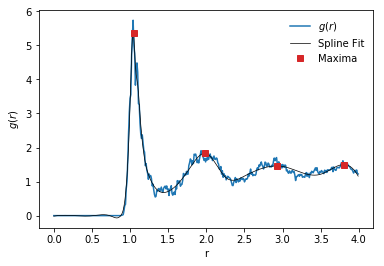

[(1.0453800000000002, array(5.37345839)), (1.9830300000000003, array(1.83078239)), (2.9246700000000003, array(1.4604134)), (3.8064600000000004, array(1.49965566))]


In [116]:
from scipy.interpolate import UnivariateSpline

density = 1
ro = r[:,:,70:]
n_times = np.shape(ro)[2]
n_parts = np.shape(ro)[1]
delta_r = 0.01
max_r = 4
# bins_array = np.zeros(max_r / delta_r)
max_vals = np.arange(0, max_r + delta_r, delta_r)   #doesnt include 4.1
bins_array = np.zeros(len(max_vals)-1)

for m in range(n_times):
    rom = ro[:,:,m]
    for i in range(n_parts-1):
        r_ij_vect = rom[i,:] - rom[(i+1):,:]   
        r_ij_vect -= np.around(r_ij_vect / box_size) * box_size   #pbc

        r_ij = np.sqrt(np.sum(r_ij_vect**2, axis=1))   # magnitude (norm) of r_ij_vect

        k = np.floor(r_ij / delta_r)

        for val in k:
            if val <= (len(bins_array) - 1):
                bins_array[int(val)] += 2


num = bins_array / (n_parts * n_times)
 
i = 0
g = []
for val in max_vals:

    if val == max_vals[0]:
        old_val = val
        continue
    
    
    h = 4 * np.pi * density / 3  * (val**3 - old_val**3)
    
    g.append(num[i] / h)
    old_val = val
    i += 1
    
# Peak finding
dist = max_vals[:-1]
g_spl = UnivariateSpline(dist, g, k=3)
g_spl.set_smoothing_factor(5)


r_arr = np.linspace(dist[0], dist[-1], 1001)

maxima_r = []
maxima_g = []
current_max_val = 0
trending_up = False
for r_val in r_arr:
    g_spl_r = g_spl(r_val)
    if g_spl_r > current_max_val:
        current_max_val = g_spl_r
        trending_up = True
    elif g_spl_r <= current_max_val and trending_up:
        maxima_r.append(r_val)
        maxima_g.append(g_spl(r_val))
        trending_up = False
    elif g_spl_r < current_max_val:
        trending_up = False
        current_max_val= g_spl_r

max_peak = maxima_g.index(max(maxima_g))
maxima_r = maxima_r[max_peak:]
maxima_g = maxima_g[max_peak:]
        
    
plt.figure()
plt.subplot(111)
plt.plot(dist, g, label='$g(r)$')
plt.plot(dist, g_spl(dist), 'k',lw=0.7, label='Spline Fit')
plt.plot(maxima_r, maxima_g, 's', c='C3',label='Maxima')
plt.xlabel('r')
plt.ylabel('$g(r)$')
plt.legend(frameon=False)
plt.show()

print(list(zip(maxima_r, maxima_g)))


In [46]:
box_size = np.array([8,8,8])    # (x, y, z)
part_props = {
    'epsilon': 1,
    'sigma': 1, 
    'mass': 1,
    'density': 0.5,
    'min_dist': 0.8,
}
time_props = {
    'delta_t': 0.001,
    'timesteps': 5000,
    'steps between out': 10    # output every n_steps steps 
}

molecular_dynamics(part_props, 'Canonical', box_size, time_props, Tsp=0.8, 
                                            save_csv=True, sim_name='Q2 - Gr2', return_results=False)

In [118]:
r2_df = pd.read_csv('Q2 - Gr2 - position.csv', index_col=0, header=[0,1])

n_parts = int(r_df.columns[-1][0]) +1
n_times = r_df.index[-1] + 1

r2 = np.zeros([n_parts, 3, n_times])
for i in range(n_parts):
    part_df = r_df[str(i)]
    for k in range(n_times):
        r2[i, :, k] = part_df.iloc[k,:]


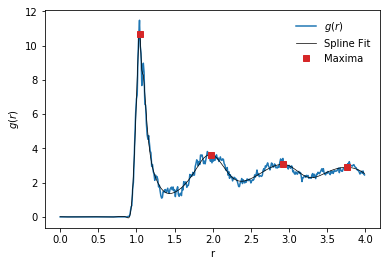

[(1.0453800000000002, array(10.6853131)), (1.9710600000000003, array(3.63483581)), (2.9166900000000004, array(3.0648211)), (3.7545900000000003, array(2.8943751))]


In [121]:
density = 0.5
ro = r2[:,:,70:]
n_times = np.shape(ro)[2]
n_parts = np.shape(ro)[1]
delta_r = 0.01
max_r = 4
# bins_array = np.zeros(max_r / delta_r)
max_vals = np.arange(0, max_r + delta_r, delta_r)   #doesnt include 4.1
bins_array = np.zeros(len(max_vals)-1)

for m in range(n_times):
    rom = ro[:,:,m]
    for i in range(n_parts-1):
        r_ij_vect = rom[i,:] - rom[(i+1):,:]   
        r_ij_vect -= np.around(r_ij_vect / box_size) * box_size   #pbc

        r_ij = np.sqrt(np.sum(r_ij_vect**2, axis=1))   # magnitude (norm) of r_ij_vect

        k = np.floor(r_ij / delta_r)

        for val in k:
            if val <= (len(bins_array) - 1):
                bins_array[int(val)] += 2


num = bins_array / (n_parts * n_times)
 
i = 0
g = []
for val in max_vals:

    if val == max_vals[0]:
        old_val = val
        continue
    
    
    h = 4 * np.pi * density / 3  * (val**3 - old_val**3)
    
    g.append(num[i] / h)
    old_val = val
    i += 1
    
# Peak finding
dist = max_vals[:-1]
g_spl = UnivariateSpline(dist, g, k=3)
g_spl.set_smoothing_factor(15)


r_arr = np.linspace(dist[0], dist[-1], 1001)

maxima_r = []
maxima_g = []
current_max_val = 0
trending_up = False
for r_val in r_arr:
    g_spl_r = g_spl(r_val)
    if g_spl_r > current_max_val:
        current_max_val = g_spl_r
        trending_up = True
    elif g_spl_r <= current_max_val and trending_up:
        maxima_r.append(r_val)
        maxima_g.append(g_spl(r_val))
        trending_up = False
    elif g_spl_r < current_max_val:
        trending_up = False
        current_max_val= g_spl_r

max_peak = maxima_g.index(max(maxima_g))
maxima_r = maxima_r[max_peak:]
maxima_g = maxima_g[max_peak:]
        
    
plt.figure()
plt.subplot(111)
plt.plot(dist, g, label='$g(r)$')
plt.plot(dist, g_spl(dist), 'k',lw=0.7, label='Spline Fit')
plt.plot(maxima_r, maxima_g, 's', c='C3',label='Maxima')
plt.xlabel('r')
plt.ylabel('$g(r)$')
plt.legend(frameon=False)
plt.show()

print(list(zip(maxima_r, maxima_g)))
